In [2]:
import os
from os.path import join
import numpy as np
import csv
import ReadDataSetup as rds
'''
Directory Setting

Read and set "ReadDataSetup.py" first!!

Also see "ReadData.py" for a quick analysis (without histogram)
'''
exp_name = 'carsnq' # read the description in "ReadDataSetup.py" first!!
onames, dirname, testname, subdirnames = rds.Setup_Directories(exp_name)
dirname += '/'

savedir = 'Analysis/'+testname+'/' # output is saved here


In [3]:
''' 
    Read results from the files
    (shows the number of data(imgs) read from the files)
'''

def read_res(fname):
    dat = np.empty([10000, 5])
    i = 0
    with open(fname, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')
        for row in reader:
            dat[i,0:4] = [int(str) for str in row[:-1]]
            if row[-1] == 'S':
                dat[i, -1] = 1
            else:
                dat[i, -1] = 0
            i+=1
    print(i)
    return dat[:i,:]


dat = {}
for oname in onames:
    first = True
    for subdirname in subdirnames:
        fname = dirname + subdirname + oname + '.csv'
        print(fname)
        if first:
            dat[oname] = read_res(fname)
            first = False
        else:
            dat[oname] = np.vstack((dat[oname], read_res(fname)))
    dat[oname] = dat[oname].astype('int')

c:\Users\Bumsu\Documents\GitHub\CARS\CARS\CARS_MNIST\CARS_NQ/0/CARS_nq_5.csv
10000


CARS_nq_5, :

   avg = 1123.52
   med = 636.0
   succ_rate = 0.9786


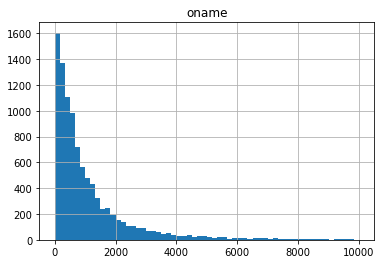

In [4]:
'''
    Make a histogram and save it in "savedir"
    Also show the success rate, and average/median queries for successful attacks, too
'''

def query_stats(dat, budget = None):
    '''
    dat = nparray (numdata)-by-5
        format: [tid, ilbl, tlbl, nevals, succ]
    '''
    if budget == None:
        budget = float('inf')
    ndat = len(dat)
    idx = (dat[:,4]>0) * (dat[:,3] <= budget)
    succ = np.sum(idx)
    succ_rate = succ/ndat
    q = dat[idx,3]
    dat[dat[:,4]==0, 3] = 999999
    ndat = succ
    np.sort(q)
    avg = np.average(q)
    med = np.median(q)
    return avg, med, succ_rate, q

import matplotlib.pyplot as plt


if not os.path.exists(savedir):
    os.makedirs(savedir)

nbins = 60
budget = 10000
nbins_reduced = 400
budget_reduced = 400
for oname in onames:
    avg, med, succ_rate, q = query_stats(dat[oname], budget)
    text2print = f'{oname}, :\n\n   avg = {avg:.2f}\n   med = {med}\n   succ_rate = {succ_rate:.4f}'
    print(text2print)
    if budget_reduced < budget:
        plt.hist(q, bins = [budget*1./nbins*i for i in range(nbins+1)], histtype='stepfilled')
        plt.title("oname")
        plt.grid()
    else:
        plt.hist(q, bins = [budget*1./nbins*i for i in range(nbins+1)], histtype='step')
        plt.title(f"budget up to {budget}")
    savefilename = savedir + oname + ".png"
    plt.savefig(savefilename, dpi=300)
    plt.show()

In [ ]:
# Cumulative Distribution Plot

import matplotlib.pyplot as plt

nbins = 60
budget = 50000
budget_reduced = 10000
nbins_reduced = min(1800, budget_reduced)
nticks = 6
xticks = [budget_reduced*1./nticks*i for i in range(0,nticks+1)]
yticks = [i*0.2 for i in range(0,5+1)]
for oname in onames:
    avg, med, succ_rate, q = query_stats(dat[oname])
    text2print = f'{oname}:\n\n   avg = {avg:.2f}\n   med = {med}\n   succ_rate = {succ_rate}'
    print(text2print)
    
    plt.hist(dat[oname][:,3], bins = [budget_reduced*1./nbins_reduced*i for i in range(nbins_reduced+1)], cumulative = True, histtype='step')
    plt.xticks(xticks)

    plt.title(f"{oname}: budget up to {budget_reduced}")
    plt.tight_layout(pad = 1.0)
    savefilename = savedir + "cumul_" +  oname + ".png"
    plt.grid()
    plt.savefig(savefilename, dpi=300)
plt.legend(onames, loc="lower right")
plt.show()

In [ ]:
# collect 'failed' images for each optimizer, for future experiments with increased budgets
failed_set = {}
for oname in onames:
    d = dat[oname]
    idx = (d[:,-1] == 0)
    failed_set[oname] = d[idx,:]
    fname = dirname + oname + '_failed.npy'
    np.save(fname, failed_set[oname][:,0:2])

In [ ]:
# Histogram of the failed labels for each optimizer

for oname in onames:
    plt.hist(failed_set[oname][:,1], bins = range(10+1))
    plt.title(f'{oname} failures on labels')
    plt.show()

*TEMP ... should be deleted later

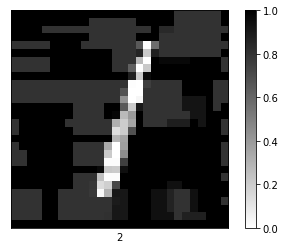

In [15]:
import numpy as np
import matplotlib.pyplot as plt
oname = 'CARS.2'
im = np.load( 'img_Results_' + oname + '_0/' + '1_0_'+ oname + '_7.npy')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(1-im, cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel('2')
plt.show()
